# In-Class Lab: A/B Testing on a Marketing Campaign

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

## Part 1: Data Exploration and Preparation

### Step 1: Load the Data
- Load the provided dataset and inspect the first few rows to understand its structure.
- Check for any missing values in the dataset.
- Verify the data types of each column.

In [370]:
data = pd.read_csv("ab_data.csv")

# check first 10 observations
data.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


### Step 2: Data Cleaning
- Identify if there are any duplicate users (i.e., users who appear in both the Control and Test groups).
- If duplicates are found, remove them from the dataset to ensure the test’s integrity.

In [371]:
#check if we have duplicates with respect to user id
data.duplicated(subset = 'user_id').sum()

data = data.drop_duplicates(subset=['user_id'])

### Step 3: Descriptive Statistics
- Calculate basic summary statistics (e.g., mean, median) for conversion rates, page views, and session time.
- Group the data by landing page and display the average conversion rate for each group.

In [372]:
conversion_stats = data['converted'].describe()
print(conversion_stats)

count    290584.000000
mean          0.119570
std           0.324458
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: converted, dtype: float64


In [373]:
converted_counts = data.groupby("landing_page")["converted"].sum()
sample_sizes = data.groupby("landing_page")["converted"].count()
conversion_rates = converted_counts / sample_sizes
print(conversion_rates)

landing_page
new_page    0.118745
old_page    0.120395
Name: converted, dtype: float64


## Part 2: Hypothesis Formulation

### Step 1: Define Hypotheses
- Based on the dataset, define your null and alternative hypotheses.
    - Null Hypothesis (H0): The new landing page has no effect on conversion rates (i.e., conversion rates are the same for both the Test and Control groups).
    - Alternative Hypothesis (H1): The new landing page increases conversion rates.

### Step 2: Data Visualization
- Create a bar plot that visualizes the conversion rates for the Test and Control groups.
- Interpret the differences (if any) in conversion rates between the two groups.

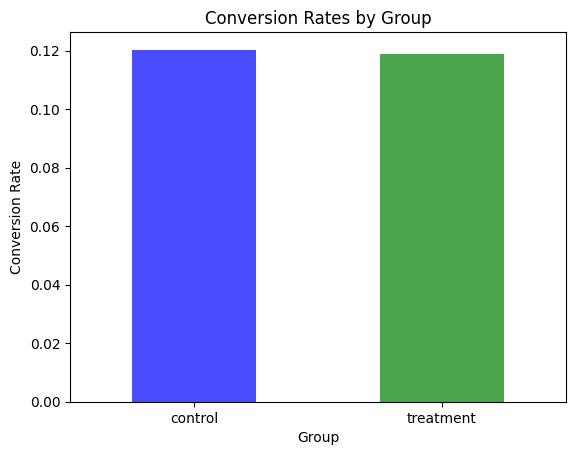

In [374]:
converted_counts = data.groupby("group")["converted"].sum()
sample_sizes = data.groupby("group")["converted"].count()
conversion_rates = converted_counts / sample_sizes
conversion_rates.plot(kind='bar', color=['blue', 'green'], alpha=0.7)
plt.title('Conversion Rates by Group')
plt.xlabel('Group')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=0)
plt.show()

## Part 3: A/B Testing (Two-Proportion Z-Test)

### Step 1: Perform a Two-Proportion Z-Test
- Using the dataset, calculate the conversion rates for both the Control and Test groups.
- Perform a two-proportion z-test to determine whether the difference in conversion rates between the Control and Test groups is statistically significant.
- Record the z-statistic and p-value from the test.

In [375]:
# Parameters
n1 = sample_sizes["control"]  # sample size control group
x1 = converted_counts["control"]  # successes control group
n2 = sample_sizes["treatment"]  # sample size treatment group
x2 = converted_counts["treatment"]  # successes treatment group
# Sample proportions
p1 = x1 / n1
p2 = x2 / n2

# Pooled proportion
p_hat = (x1 + x2) / (n1 + n2)
# Standard error
se = math.sqrt(p_hat * (1 - p_hat) * ((1 / n1) + (1 / n2)))
# z-test statistic
z = (p1 - p2) / se
# p-value (two-tailed test)
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

# Output the results
print(f"Z-score: {z}")
print(f"P-value: {p_value}")

Z-score: 1.2083846739740718
P-value: 0.22689933216132774


### Step 2: Interpretation
- Based on the p-value, decide whether to reject or fail to reject the null hypothesis.
- Discuss the business implications of your findings—should the company switch to the new landing page?

In [376]:
# Output the conclusion
isRejected = True if p_value < 0.05 else False
if isRejected:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

Fail to reject the null hypothesis.


## Part 4: Confidence Intervals and Visualization

### Step 1: Confidence Intervals
- Calculate the 95% confidence intervals for the conversion rates of both the Test and Control groups.
- Discuss what the confidence intervals indicate about the reliability of the results.

In [377]:
confidence_intervals = {}
for group in ["control", "treatment"]:
    conversions = data[data["group"] == group]["converted"]
    n = len(conversions)
    p = conversions.mean()
    Z = 1.96
    se = np.sqrt(p * (1 - p) / n)

    lower_bound = p - Z * se
    upper_bound = p + Z * se

    confidence_intervals[group] = {
        "Conversion Rate": p,
        "95% CI Lower": lower_bound,
        "95% CI Upper": upper_bound,
    }

df_confidence_intervals = pd.DataFrame(confidence_intervals).T
print(df_confidence_intervals)

           Conversion Rate  95% CI Lower  95% CI Upper
control           0.120297      0.118624      0.121970
treatment         0.118843      0.117179      0.120506


### Step 2: Visualization of Confidence Intervals
- Create a plot that shows the conversion rates for both groups, including the confidence intervals as error bars.

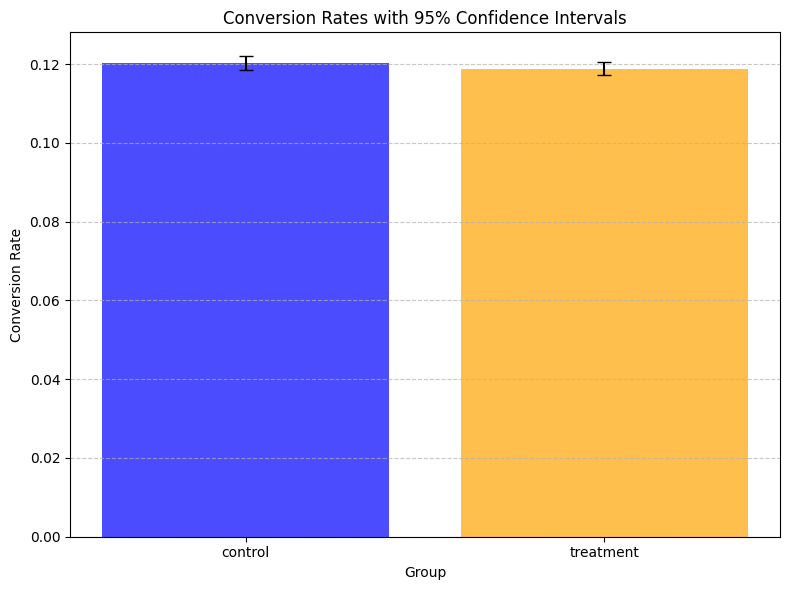

In [378]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(df_confidence_intervals.index, df_confidence_intervals["Conversion Rate"], 
       yerr=[df_confidence_intervals["Conversion Rate"] - df_confidence_intervals["95% CI Lower"],
             df_confidence_intervals["95% CI Upper"] - df_confidence_intervals["Conversion Rate"]],
       capsize=5, color=['blue', 'orange'], alpha=0.7)

ax.set_xlabel('Group')
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rates with 95% Confidence Intervals')

ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Part 5: Subgroup Analysis

### Step 1: Time-Based Analysis
- Using the timestamp data, extract the hour of the day that each user visited the website.
- Group the data by hour and calculate the conversion rates for each hour.
- Create a line plot that shows how conversion rates vary by the time of day.

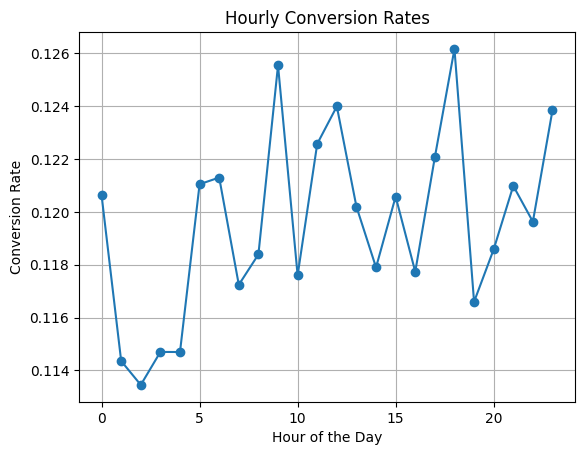

In [379]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

data['hour'] = data['timestamp'].dt.hour
hourly_conversion = data.groupby('hour')['converted'].mean()

plt.plot(hourly_conversion.index, hourly_conversion.values, marker='o')
plt.title('Hourly Conversion Rates')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Rate')
plt.grid()
plt.show()

### Step 2: Interpretation
- Analyze the conversion rate trends over different times of day.
- Identify if there are any specific time periods where the new landing page was more or less effective.  

The conversion rate appears to be higher around 9 a.m. and 6 p.m. In contrast, it is lowest between 1 a.m. and 4 a.m.
The new landing page could be more effective at around 9 am and at around 6 pm whereas less effective between 1 am and 4 am.

## Part 6: Conclusion

### Step 1: Summarize Findings
- Summarize the results of your A/B test, including whether the new landing page showed a statistically significant improvement in conversion rates.
- Discuss any additional insights gained from the confidence intervals and subgroup analysis.

In [380]:
# Print the summary
print(df_confidence_intervals)

print(f"P-value: {p_value}")

isRejected = True if p_value < 0.05 else False
if isRejected:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")

           Conversion Rate  95% CI Lower  95% CI Upper
control           0.120297      0.118624      0.121970
treatment         0.118843      0.117179      0.120506
P-value: 0.22689933216132774
Fail to reject the null hypothesis.


### Step 2: Recommendations
- Based on your analysis, recommend whether the company should adopt the new landing page.
- Highlight any potential limitations of the A/B test, such as sample size, duration of the test, or external factors.

Here, the null hypothesis could not be rejected, indicating that a significant difference was not confirmed.  
As the conversion rate seems to be high during a specific time period, it might be effective to consider targeting measures for that time period.